<a href="https://colab.research.google.com/github/aliasgharchakera/GPU-Spring24-Assignment01/blob/main/AY06993_Assgn1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 432 GPU Accelerated Programming
## Assignment 1
### Ali Asghar Yousuf
### ay06993@st.habib.edu.pk

### Initialization

In [10]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc4jupyter

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-_9fsai6z
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-_9fsai6z
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 5cd225851b7638f3f6d55a19328295f16c014079
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
The nvcc4jupyter extension is already loaded. To reload it, use:
  %reload_ext nvcc4jupyter


In [11]:
!nvidia-smi

Mon Jan 29 17:10:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Part I: Memory Initialization and Copying

In [49]:
%%cuda
#include <stdio.h>
#include <curand_kernel.h>
#include <time.h>

inline cudaError_t checkCudaErr(cudaError_t err, const char* msg) {
  if (err != cudaSuccess) {
    fprintf(stderr, "CUDA Runtime error at %s: %s\n", msg, cudaGetErrorString(err));
  }
  return err;
}

__global__ void InitData(int* data, const int N)
{
    curandState_t state;
    curand_init(clock64(), 0, 0, &state);
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    if (idx < N) {
        data[idx] = curand(&state) % 100;
    }
}

int main()
{
  int* h_data = 0;
  int* d_data = 0;
  clock_t start = 0;

  const int sizes[] = {1000, 10000, 100000, 1000000};
  const int numSizes = 4;
  double cpuTimes[numSizes];
  double gpuTimes[numSizes];
  double copyTimes[numSizes];

  //allocate memory on device
  cudaMalloc((void **)&d_data, 10*sizeof(int));

  InitData<<<1, 10>>>(d_data, 10);
  checkCudaErr(cudaDeviceSynchronize(), "Syncronization");
  cudaFree(d_data);
  // Open a file for writing
  FILE *f = fopen("init_timings.txt", "w");
  if (f == NULL) {
      printf("Error opening file!\n");
      return 1;
  }

  // Different execution configurations
  const int threadConfigs[] = {32, 64, 128, 256, 512};
  const int numConfigs = 5;

  for (int c = 0; c < numConfigs; ++c) {
    int numThreadsPerBlock = threadConfigs[c];

    for (int s = 0; s < numSizes; ++s) {
      const int N = sizes[s];
      int numBlocksPerGrid = ceilf(N/numThreadsPerBlock + 1);
      size_t size = N * sizeof(int);

      h_data = (int*)malloc(size);
      //calculate on host
      start = clock();
      for (int i = 0; i < N; i++) {
          h_data[i] = rand() % 100;
      }
      cpuTimes[s] = (double)(clock() - start) / CLOCKS_PER_SEC;

      //allocate memory on device
      cudaMalloc((void **)&d_data, size);

      //calculate on device
      start = clock();
      InitData<<<numBlocksPerGrid, numThreadsPerBlock>>>(d_data, N);
      checkCudaErr(cudaDeviceSynchronize(), "Syncronization");
      gpuTimes[s] = (double)(clock() - start) / CLOCKS_PER_SEC;

      //copy device data to host memory
      start = clock();
      checkCudaErr(cudaMemcpy(h_data, d_data, N*sizeof(int), cudaMemcpyDeviceToHost), "cudaMemcpy D->H");
      copyTimes[s] = (double)(clock() - start) / CLOCKS_PER_SEC;

      //release memory
      cudaFree(d_data);
      free(h_data);

      // Write to file
      fprintf(f, "%d\t%d\t%d\t%f\t%f\t%f\n", N, numThreadsPerBlock, numBlocksPerGrid, cpuTimes[s], gpuTimes[s], copyTimes[s]);
    }
  }

  fclose(f);

  return 0;
}

#### Plotting the results of Part I for different execution configurations

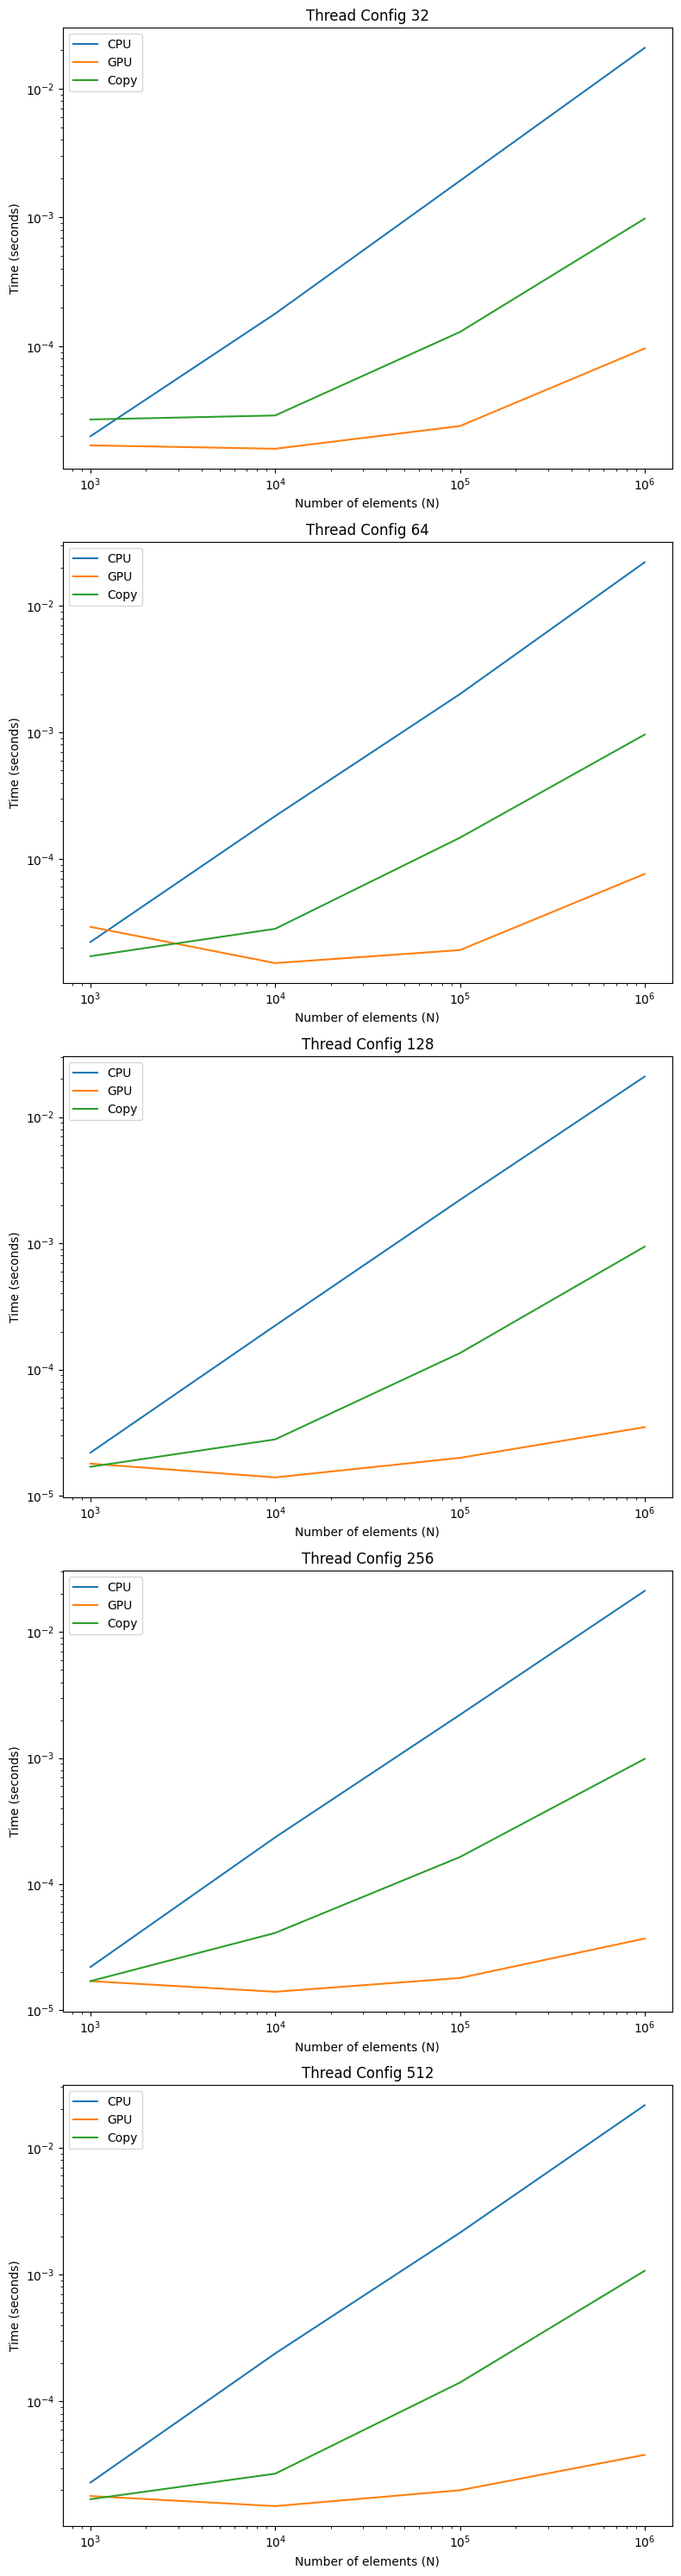

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Read the timing results from the file
with open('init_timings.txt') as f:
    data = f.readlines()

# Parse the data
sizes = []
thread_configs = []
num_blocks_per_grids = []
cpu_times = []
gpu_times = []
copy_times = []
for line in data:
    line = line.strip()
    values = line.split('\t')
    sizes.append(int(values[0]))
    thread_configs.append(int(values[1]))
    num_blocks_per_grids.append(int(values[2]))
    cpu_times.append(float(values[3]))
    gpu_times.append(float(values[4]))
    copy_times.append(float(values[5]))

# Create a color map for different thread configs
color_map = plt.get_cmap('tab10')

# Get unique thread configs
unique_thread_configs = (list(set(thread_configs)))
unique_thread_configs.sort()

# Create subplots for each thread config
fig, axs = plt.subplots(len(unique_thread_configs), 1, figsize=(8, 6 * len(unique_thread_configs)))

# Plot for each thread config
for i, config in enumerate(unique_thread_configs):
    indices = [j for j, x in enumerate(thread_configs) if x == config]
    ax = axs[i]
    ax.plot(np.array(sizes)[indices], np.array(cpu_times)[indices], label='CPU', color=color_map(0))
    ax.plot(np.array(sizes)[indices], np.array(gpu_times)[indices], label='GPU', color=color_map(1))
    ax.plot(np.array(sizes)[indices], np.array(copy_times)[indices], label='Copy', color=color_map(2))
    ax.set_xlabel('Number of elements (N)')
    ax.set_ylabel('Time (seconds)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'Thread Config {config}')
    ax.legend(loc='upper left')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


As visible from the graph, we see that data initialization on the CPU is linear, whereas on the GPU it is almost constant (for the values of N that we have tested). This is because the GPU is able to initialize the data in parallel, whereas the CPU does it sequentially.

Another interesting observation is that the time taken to copy the data from the GPU to the CPU is much higher than the time required to initialize the data on the GPU. This is because the GPU has to copy the data from its memory to the CPU's memory which is bottlenecked by the speed of the PCI-E bus, which is much slower than the speed of the GPU's memory, as we discussed in class.

### Part II: Calculation

#### Mistakenly incorrect solution (submitted earlier)

In [7]:
%%cuda
#include <stdio.h>
#include <time.h>

inline cudaError_t checkCudaErr(cudaError_t err, const char* msg) {
  if (err != cudaSuccess) {
    fprintf(stderr, "CUDA Runtime error at %s: %s\n", msg, cudaGetErrorString(err));
  }
  return err;
}

__global__ void SumDevice(int* a, int* b, int* c, const int N) {
    int i = threadIdx.x + blockDim.x * blockIdx.x;
    if (i<N) {
        c[i] = a[i] + b[i];
    }
}

void SumHost(int* a, int* b, int* c, const int N) {
    for (int i = 0; i < N; ++i) {
        c[i] = a[i] + b[i];
    }
}

int main() {
    int* h_a = 0;
    int* h_b = 0;
    int* h_c = 0;

    int* d_a = 0;
    int* d_b = 0;
    int* d_c = 0;

    const int sizes[] = {1000, 10000, 100000, 1000000};
    const int numSizes = 4;
    double cpuTimes[numSizes];
    double gpuTimes[numSizes];
		double copyTimes[numSizes];

		//Get the gpu up and running, since the first call usually takes some overhead time to start
		//allocate device memory
		cudaMalloc((void**)&d_a, 10*sizeof(int));
		cudaMalloc((void**)&d_b, 10*sizeof(int));
		cudaMalloc((void**)&d_c, 10*sizeof(int));
		//calculate on device
		SumDevice<<<1, 10>>>(d_a, d_b, d_c, 10);
		checkCudaErr(cudaDeviceSynchronize(), "Syncronization");

		//delete data allocated on device
		cudaFree(d_a);
		cudaFree(d_b);
		cudaFree(d_c);

		// Open a file for writing
    FILE *f = fopen("sum_timings.txt", "w");
    if (f == NULL) {
        printf("Error opening file!\n");
        return 1;
    }

		// Different execution configurations
    const int threadConfigs[] = {32, 64, 128, 256, 512};
    const int numConfigs = 5;

		for (int c = 0; c < numConfigs; ++c) {
      int numThreadsPerBlock = threadConfigs[c];

			for (int s = 0; s < numSizes; ++s) {
				const int N = sizes[s];
				int numBlocksPerGrid = ceilf(N/numThreadsPerBlock + 1);
				size_t size = N * sizeof(int);

				//allocate host memory
				h_a = (int*)malloc(size);
				h_b = (int*)malloc(size);
				h_c = (int*)malloc(size);

				//allocate device memory
				cudaMalloc((void**)&d_a, size);
				cudaMalloc((void**)&d_b, size);
				cudaMalloc((void**)&d_c, size);

				//calculate on host
				clock_t start = clock();
				SumHost(h_a, h_b, h_c, N);
				cpuTimes[s] = (double)(clock() - start) / CLOCKS_PER_SEC;

				//calculate on device
				start = clock();
				SumDevice<<<numBlocksPerGrid, numThreadsPerBlock>>>(d_a, d_b, d_c, N);
				checkCudaErr(cudaDeviceSynchronize(), "Syncronization");
				gpuTimes[s] = (double)(clock() - start) / CLOCKS_PER_SEC;

				//copy result from device to host
				start = clock();
				checkCudaErr(cudaMemcpy(h_a, d_a, N*sizeof(int), cudaMemcpyDeviceToHost), "cudaMemcpy D->H");
				checkCudaErr(cudaMemcpy(h_b, d_b, N*sizeof(int), cudaMemcpyDeviceToHost), "cudaMemcpy D->H");
				checkCudaErr(cudaMemcpy(h_c, d_c, N*sizeof(int), cudaMemcpyDeviceToHost), "cudaMemcpy D->H");
				copyTimes[s] = (double)(clock() - start) / CLOCKS_PER_SEC;

				//delete data allocated on device
				cudaFree(d_a);
				cudaFree(d_b);
				cudaFree(d_c);

				//delete host memory
				free(h_a);
				free(h_b);
				free(h_c);

				// Write the results to the file
				fprintf(f, "%d\t%d\t%d\t%f\t%f\t%f\n", N, numThreadsPerBlock, numBlocksPerGrid, cpuTimes[s], gpuTimes[s], copyTimes[s]);
			}
		}

    // Close the file
    fclose(f);
    return 0;
}


#### Correct Solution (Final Submission)

In [93]:
%%cuda
#include <stdio.h>
#include <cuda_runtime.h>

#define MAX_THREADS_PER_BLOCK 1024

inline cudaError_t checkCudaErr(cudaError_t err, const char* msg) {
  if (err != cudaSuccess) {
    fprintf(stderr, "CUDA Runtime error at %s: %s\n", msg, cudaGetErrorString(err));
  }
  return err;
}

//kernel function to calculate the sum of an array
__global__ void sumArray(int *arr, int *result, const int N) {
    int tid = threadIdx.x;
    int numThreads = blockDim.x;

    //initialize shared memory
    __shared__ int partialSum[MAX_THREADS_PER_BLOCK];

    partialSum[tid] = 0;

    //calculate partial sum for each block
    for (int i = tid; i < N; i += numThreads) {
        partialSum[tid] += arr[i];
    }
    //wait for all threads in the block to finish
    __syncthreads();

    //reduce partial sums
    for (int s = blockDim.x / 2; s > 0; s >>= 1) {
        if (tid < s) {
            partialSum[tid] += partialSum[tid + s];
        }
        __syncthreads();
    }

    //write the result back to global memory
    if (tid == 0) {
        *result = partialSum[0];
    }
}

int main() {
    const int threadConfigs[] = {32, 64, 128, 256, 512, 1024};
    const int numConfigs = 6;

    int sizes[] = {1000, 10000, 100000, 1000000, 10000000};
    int numSizes = 5;

    int *d_arr, *d_result;
    int h_result, *h_arr;
    clock_t start = 0;

    //GPU startup
    cudaMalloc((void **)&d_arr, 10 * sizeof(int));
    cudaMalloc((void **)&d_result, sizeof(int));

    sumArray<<<1, 16>>>(d_arr, d_result, 10);
    checkCudaErr(cudaDeviceSynchronize(), "Syncronization");
    cudaFree(d_arr);
    //open a file for writing
    FILE *f = fopen("sum_timings.txt", "w");
    if (f == NULL) {
        printf("Error opening file!\n");
        return 1;
    }

    double cpuTimes[numSizes];
    double gpuTimes[numSizes];
    double copyTimes[numSizes];

    for (int c = 0; c < numConfigs; ++c) {
        int numThreadsPerBlock = threadConfigs[c];
        for (int s = 0; s < numSizes; ++s) {
          int N = sizes[s];
          int numBlocksPerGrid = ceilf(N/numThreadsPerBlock + 1);
          size_t size = N * sizeof(int);

          //allocate host memory
          h_arr = (int *)malloc(N * sizeof(int));

          //populate array with 1s
          for (int i = 0; i < N; ++i) {
              h_arr[i] = 1;
          }

          cudaMalloc((void **)&d_arr, N * sizeof(int));
          cudaMalloc((void **)&d_result, sizeof(int));

          //copy array from CPU to GPU
          checkCudaErr(cudaMemcpy(d_arr, h_arr, N * sizeof(int), cudaMemcpyHostToDevice), "cudaMemcpy H->D");

          //calculate sum on GPU
          start = clock();
          sumArray<<<numBlocksPerGrid, numThreadsPerBlock>>>(d_arr, d_result, N);
          checkCudaErr(cudaDeviceSynchronize(), "Syncronization");
          gpuTimes[s] = (double)(clock() - start) / CLOCKS_PER_SEC;

          //copy result from GPU to CPU
          start = clock();
          checkCudaErr(cudaMemcpy(&h_result, d_result, sizeof(int), cudaMemcpyDeviceToHost), "cudaMemcpy D->H");
          copyTimes[s] = (double)(clock() - start) / CLOCKS_PER_SEC;
          printf("Configuration %d, %d (N=%d) - GPU Result: %d\n", numThreadsPerBlock, numBlocksPerGrid, N, h_result);

          //calculate sum on CPU
          int cpu_result = 0;
          start = clock();
          for (int i = 0; i < N; ++i) {
              cpu_result += h_arr[i];
          }
          cpuTimes[s] = (double)(clock() - start) / CLOCKS_PER_SEC;

          //free memory
          free(h_arr);
          cudaFree(d_arr);
          cudaFree(d_result);

          //write the results to the file
				  fprintf(f, "%d\t%d\t%d\t%f\t%f\t%f\n", N, numThreadsPerBlock, numBlocksPerGrid, cpuTimes[s], gpuTimes[s], copyTimes[s]);
			}
		}

    // Close the file
    fclose(f);
    return 0;
}


Configuration 32, 32 (N=1000) - GPU Result: 1000
Configuration 32, 313 (N=10000) - GPU Result: 10000
Configuration 32, 3126 (N=100000) - GPU Result: 100000
Configuration 32, 31251 (N=1000000) - GPU Result: 1000000
Configuration 32, 312501 (N=10000000) - GPU Result: 10000000
Configuration 64, 16 (N=1000) - GPU Result: 1000
Configuration 64, 157 (N=10000) - GPU Result: 10000
Configuration 64, 1563 (N=100000) - GPU Result: 100000
Configuration 64, 15626 (N=1000000) - GPU Result: 1000000
Configuration 64, 156251 (N=10000000) - GPU Result: 10000000
Configuration 128, 8 (N=1000) - GPU Result: 1000
Configuration 128, 79 (N=10000) - GPU Result: 10000
Configuration 128, 782 (N=100000) - GPU Result: 100000
Configuration 128, 7813 (N=1000000) - GPU Result: 1000000
Configuration 128, 78126 (N=10000000) - GPU Result: 10000000
Configuration 256, 4 (N=1000) - GPU Result: 1000
Configuration 256, 40 (N=10000) - GPU Result: 10000
Configuration 256, 391 (N=100000) - GPU Result: 100000
Configuration 256, 

#### Plotting the results of Part II for different execution configurations

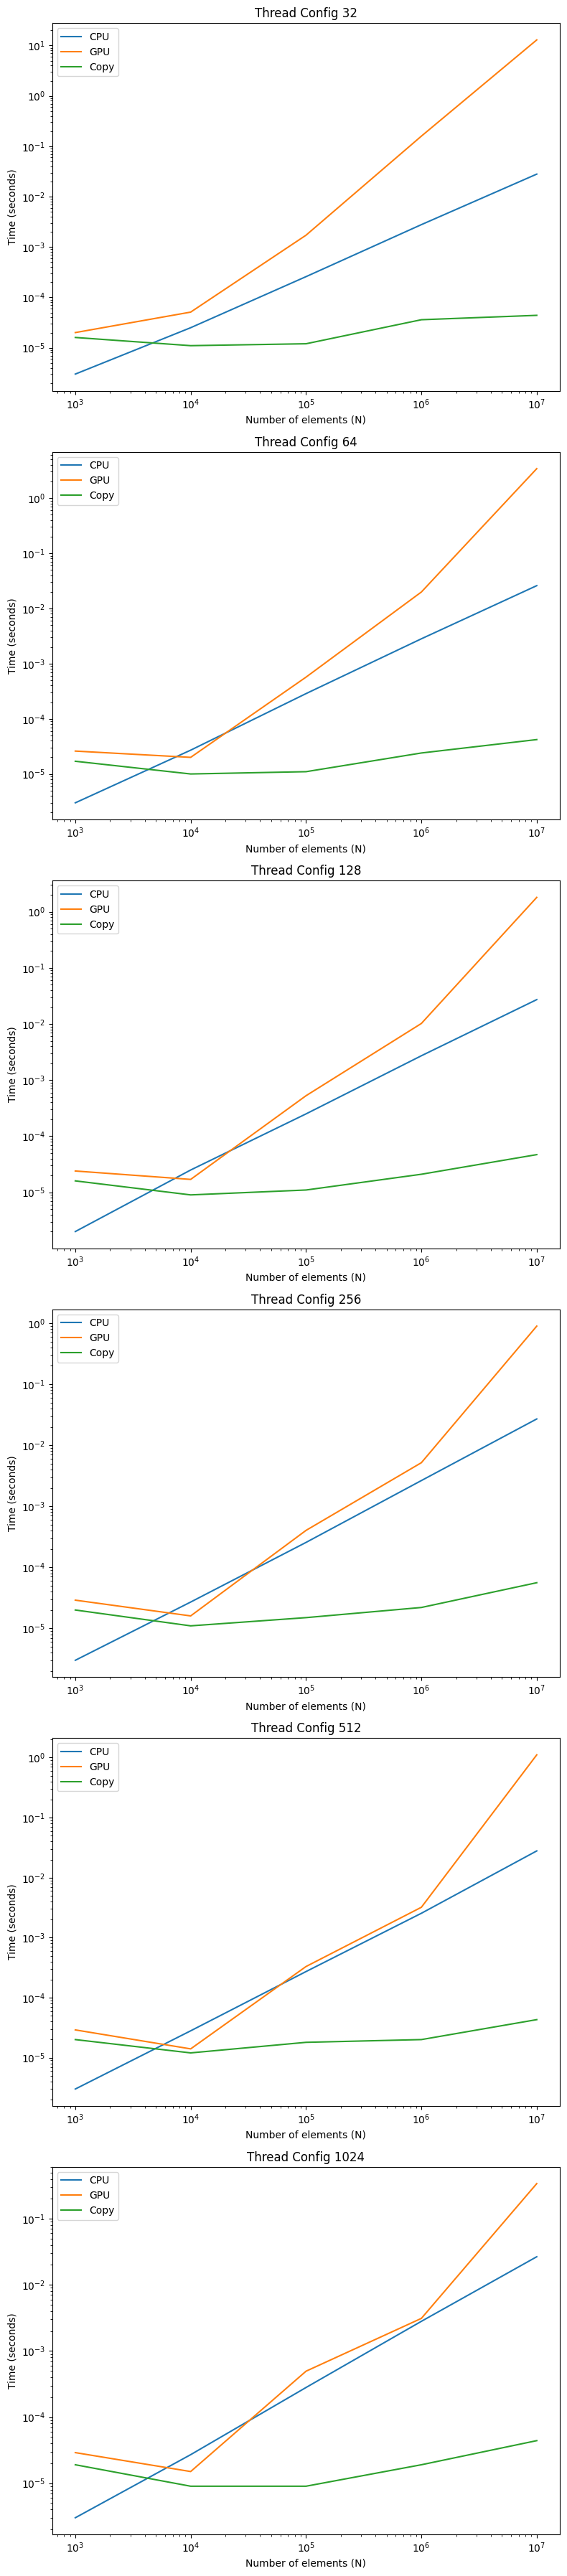

In [94]:
import matplotlib.pyplot as plt
import numpy as np

# Read the timing results from the file
with open('sum_timings.txt') as f:
    data = f.readlines()

# Parse the data
sizes = []
thread_configs = []
num_blocks_per_grids = []
cpu_times = []
gpu_times = []
copy_times = []
for line in data:
    line = line.strip()
    values = line.split('\t')
    sizes.append(int(values[0]))
    thread_configs.append(int(values[1]))
    num_blocks_per_grids.append(int(values[2]))
    cpu_times.append(float(values[3]))
    gpu_times.append(float(values[4]))
    copy_times.append(float(values[5]))

# Create a color map for different thread configs
color_map = plt.get_cmap('tab10')

# Get unique thread configs
unique_thread_configs = (list(set(thread_configs)))
unique_thread_configs.sort()

# Create subplots for each thread config
fig, axs = plt.subplots(len(unique_thread_configs), 1, figsize=(8, 6 * len(unique_thread_configs)))

# Plot for each thread config
for i, config in enumerate(unique_thread_configs):
    indices = [j for j, x in enumerate(thread_configs) if x == config]
    ax = axs[i]
    ax.plot(np.array(sizes)[indices], np.array(cpu_times)[indices], label='CPU', color=color_map(0))
    ax.plot(np.array(sizes)[indices], np.array(gpu_times)[indices], label='GPU', color=color_map(1))
    ax.plot(np.array(sizes)[indices], np.array(copy_times)[indices], label='Copy', color=color_map(2))
    ax.set_xlabel('Number of elements (N)')
    ax.set_ylabel('Time (seconds)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'Thread Config {config}')
    ax.legend(loc='upper left')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


Once again we see a very linear trend for the CPU, whereas the GPU curve is non linear. While the GPU takes higher time at smaller values of N, it comes close to the CPU as N grows larger but to an extent, after which the slope of the GPU curve increases. We also see that as we increase the number of threads per block, the curve has a less steeper slope, however, as N approaches 1,000,000 it starts to deviate and the slope increases.

The variation in the GPU's performance is partly due to the way we are calculating the sum of the array elements. We are using a reduction algorithm, which is a divide and conquer algorithm. The algorithm divides the array into smaller parts and calculates the sum of each part, and then adds the sums of the parts to get the final sum. This is done recursively until we get the final sum. The number of parts is equal to the number of threads per block. As we increase the number of threads per block, the number of parts decreases, and the number of recursive calls decreases, which results in a faster calculation.

However, this efficiency gain has its limits. As N nears 1,000,000, the number of parts becomes so big that the overhead of creating threads and calling the recursive function becomes greater than the time saved by the reduction algorithm. This is why we see the slope of the curve increasing as N approaches 1,000,000.

### References

1. [Error Catching](https://github.com/mmmovania/CUDA_Spring_2024/blob/main/Week2/InitDataOnGPU.ipynb)
2. [Timing](https://github.com/mmmovania/CUDA_Spring_2024/blob/main/Week3/Calculate_SumOnGPU_Timed.ipynb)
3. [CuRAND](https://docs.nvidia.com/cuda/curand/index.html)
4. [ILE C/C++ Runtime Library Functions](https://www.ibm.com/docs/en/rdfi/9.6.0?topic=functions-clock-determine-processor-time)
5. [Tutorials Point](https://www.tutorialspoint.com/c_standard_library/time_h.htm)
6. [C Write To Files](https://www.w3schools.com/c/c_files_write.php)
7. [NVIDIA Optimizing Parallel Reduction in CUDA](https://developer.download.nvidia.com/assets/cuda/files/reduction.pdf)


Plotting was done with the help of [Github Copilot](https://copilot.github.com/) autocomplete as it helps in writing code much faster.